In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import re
import datetime
import dateutil.parser
import statistics 
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import graphviz
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree, metrics


In [2]:
df = pd.read_csv('Indian Earthquakes List Update_Magnitudes (1).csv',header=8, encoding = "ISO-8859-1", parse_dates=True)

/home/varun/LE-Course/Sem2/SMAI/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0,1,2,3,6,7,9,10,11,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.columns = ( df.iloc[0].fillna('') + df.iloc[1].fillna(''))
df.columns = np.vectorize(lambda x: x.strip())(df.columns)

In [4]:
df = df.drop([0,1])
df = df.reset_index(drop=True)

In [5]:
df

,Sl. No.,YEAR,MONTH,DATE,ORIGIN TIME(UTC),(IST),MAGNITUDEMw,Mw,Mb,Mb,Ms,ML,LAT (N),LONG (E),DEPTH (km),INTENSITYMM,MMI,MME,LOCATION,REFERENCE
0,1,-2474,0,0,NaN,NaN,7.5,7.5,NaN,6.969202899,7.260619977,7.427072403,71,24,0,NaN,NaN,NaN,NaN,Dr STGR
1,2,-325,0,0,NaN,NaN,7.5,7.5,NaN,6.969202899,7.260619977,7.427072403,71,24,0,NaN,NaN,NaN,NaN,Dr STGR
2,3,25,0,0,NaN,NaN,7.5,7.5,NaN,6.969202899,7.260619977,7.427072403,72.9,33.72,0,NaN,NaN,NaN,NaN,Dr STGR
3,4,26,5,10,08.19.10.0,NaN,6.1397,6.1397,5.737047101,5.737047101,5.698851894,5.999685205,17.3,80.1,NaN,NaN,NaN,NaN,NaN,NEIC
4,5,26,5,10,08.19.10.0,NaN,6.1397,6.1397,5.737047101,5.737047101,6.075520196,5.999685205,26,97,80,NaN,NaN,NaN,Myanmar,G-R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52984,52970,2019,7,28,19:24:08,00:54:08/2019-07-29/,3.2,3.2,NaN,3.07428,2.32377,2.91501,32.8°N,78.4°E,10,NaN,NaN,NaN,Jammu & Kashmir,NaN
52985,52971,2019,7,28,10:44:10,16:14:10,3.6,3.6,NaN,3.43659,2.78301,3.33473,25.5°N,90.4°E,70,NaN,NaN,NaN,"Distt. East Garo Hills ,Meghalaya",NaN
52986,52972,2019,7,28,21:25:06,7/29/2019 2:55,4,4,NaN,3.79891,3.24225,3.75446,23.2°N,86.5°E,22,NaN,NaN,NaN,"Distt. Puruliya, West Bengal",NaN
52987,52973,2019,7,29,3:33:53,9:03:53,4.3,4.3,NaN,4.07065,3.58668,4.06925,32.8°N,76.4°E,20,NaN,NaN,NaN,"Distt. Lahaul-Spiti,Himachal Pradesh",NaN


In [6]:
def ints(x):
    if pd.notna(x):
        if (type(x) == str and x.strip().isdigit()):
            return int(x.strip())
        elif (type(x) in [int, float]):
            return int(x)
        else:
            return -1
    return -1

In [7]:
def floats(x):
    if pd.notna(x):
        if (type(x) == str and x.strip().isdigit()):
            return int(x.strip())
        elif (type(x) in [int, float]):
            return float(x)
        else:
            return -1
    return -1

In [8]:
for col in ['YEAR','DATE','MONTH']:
#     df[col] = df[col].dropna()
    df[col] = df[col].apply(ints)

In [9]:
for col in ['Mw','MAGNITUDEMw']:
#     df[col] = df[col].dropna()
    df[col] = df[col].apply(floats)

In [10]:
df = df.drop(np.where((df['YEAR']<=0)|(df['MONTH']<=0) | (df['DATE']<=0))[0])

In [11]:
df = df.drop(df.index[df['Mw']<=0])

In [12]:
np.where(df['ORIGIN TIME(UTC)'].isna() & df['(IST)'].notna())

(array([], dtype=int64),)

In [13]:
np.where(df['ORIGIN TIME(UTC)'].notna() & df['(IST)'].isna())

(array([   15,    18,    22, ..., 19731, 19732, 19733]),)

In [14]:
np.where(df['MAGNITUDEMw'].notna() & df['Mw'].isna())

(array([], dtype=int64),)

In [15]:
np.where(df['MAGNITUDEMw'].isna() & df['Mw'].notna())

(array([], dtype=int64),)

In [16]:
def formatint(x):
    if pd.notna(x):
        if (type(x) == str and x.strip().isdigit()):
            return int(x.strip())
        elif (type(x) in [int, float]):
            return int(x)
        else:
#             print(x)
            return pd.NA
    return x

In [17]:
def formatfloat(x):
    if pd.notna(x):
        if (type(x) == str and x.strip().isdigit()):
            return int(x.strip())
        elif (type(x) in [int, float]):
            return float(x)
        else:
#             print(x)
            return pd.NA
    return x

In [18]:
df['MAGNITUDEMw'] = df['MAGNITUDEMw'].apply(formatfloat)

In [19]:
df

,Sl. No.,YEAR,MONTH,DATE,ORIGIN TIME(UTC),(IST),MAGNITUDEMw,Mw,Mb,Mb,Ms,ML,LAT (N),LONG (E),DEPTH (km),INTENSITYMM,MMI,MME,LOCATION,REFERENCE
332,318,1852,3,31,NaN,NaN,6.0,6.0,5.610507246,5.610507246,5.538461538,5.853095488,26.17,85.9,NaN,NaN,NaN,NaN,NaN,NEIC
449,435,1863,11,18,NaN,NaN,5.0,5.0,4.704710145,4.704710145,4.390355913,4.803777545,26.47,84.43,NaN,NaN,NaN,NaN,NaN,NEIC
572,558,1871,1,31,NaN,NaN,5.0,5.0,4.704710145,4.704710145,4.390355913,4.803777545,16.98,82.33,NaN,NaN,NaN,NaN,NaN,NEIC
590,576,1872,4,14,NaN,NaN,5.0,5.0,4.704710145,4.704710145,4.390355913,4.803777545,26.3,89.53,NaN,NaN,NaN,NaN,NaN,NEIC
645,631,1882,6,28,NaN,NaN,5.0,5.0,4.704710145,4.704710145,4.390355913,4.803777545,22.6,93.4,NaN,NaN,NaN,NaN,NaN,NEIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52984,52970,2019,7,28,19:24:08,00:54:08/2019-07-29/,3.2,3.2,NaN,3.07428,2.32377,2.91501,32.8°N,78.4°E,10,NaN,NaN,NaN,Jammu & Kashmir,NaN
52985,52971,2019,7,28,10:44:10,16:14:10,3.6,3.6,NaN,3.43659,2.78301,3.33473,25.5°N,90.4°E,70,NaN,NaN,NaN,"Distt. East Garo Hills ,Meghalaya",NaN
52986,52972,2019,7,28,21:25:06,7/29/2019 2:55,4.0,4.0,NaN,3.79891,3.24225,3.75446,23.2°N,86.5°E,22,NaN,NaN,NaN,"Distt. Puruliya, West Bengal",NaN
52987,52973,2019,7,29,3:33:53,9:03:53,4.3,4.3,NaN,4.07065,3.58668,4.06925,32.8°N,76.4°E,20,NaN,NaN,NaN,"Distt. Lahaul-Spiti,Himachal Pradesh",NaN


In [20]:
df = df[['YEAR', 'MONTH', 'DATE', 'ORIGIN TIME(UTC)', 'Mw', 'LAT (N)', 'LONG (E)',
       'DEPTH (km)', 'REFERENCE']]

In [21]:
df.head()

,YEAR,MONTH,DATE,ORIGIN TIME(UTC),Mw,LAT (N),LONG (E),DEPTH (km),REFERENCE
332,1852,3,31,NaN,6.0,26.17,85.9,NaN,NEIC
449,1863,11,18,NaN,5.0,26.47,84.43,NaN,NEIC
572,1871,1,31,NaN,5.0,16.98,82.33,NaN,NEIC
590,1872,4,14,NaN,5.0,26.3,89.53,NaN,NEIC
645,1882,6,28,NaN,5.0,22.6,93.4,NaN,NEIC


In [22]:
df['ORIGIN TIME(UTC)'].fillna('00:00:00',inplace=True)
df['DEPTH (km)'].fillna(0,inplace=True)
df['REFERENCE'].fillna('',inplace=True)

/home/varun/LE-Course/Sem2/SMAI/env/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [23]:
df['ORIGIN TIME(UTC)']!=0

332      True
449      True
572      True
590      True
645      True
         ... 
52984    True
52985    True
52986    True
52987    True
52988    True
Name: ORIGIN TIME(UTC), Length: 20160, dtype: bool

In [24]:
def time2str(x):
    if type(x) in [int,float]:
        x = x/1000.0
        return datetime.datetime.fromtimestamp(s).strftime('%H:%M:%S.%f')
    x = x.replace(' ',':')
    x = x.replace('.',':')
    flag = (x.find('PM') > -1)
    x = re.sub('[^0-9.:]*', '', x)
    
    x = np.array([ int(t) if t.isdigit() else -1 for t in x.split(':')])
    x = x[x>=0]
    
    x_ = np.zeros(4)
    try:
        x_[:x.shape[0]] = x
    except:
        print(x)
    
    if flag:
        x_[0] = x_[0] + (12 if x_[0]<12 else 0)
    x_ = np.min(np.vstack([x_,np.array([23,59,59,99])]),axis = 0)
    return '{}:{}:{}.{}'.format(int(x_[0]),int(x_[1]),int(x_[2]),int(x_[3]))
#     return np.sum(x_ * np.array([3600,60,1,0.01]))

In [25]:
def cols2timestamp(row):
    year=row['YEAR']
    month=row['MONTH']
    day=row['DATE']
    time = '' if pd.isnull(row['ORIGIN TIME(UTC)']) else time2str(row['ORIGIN TIME(UTC)'])
    try:
        x = dateutil.parser.parse('{}-{}-{} {}'.format(year,month,day,time))
    except:
        x = dateutil.parser.parse('{}-{}-{} {}'.format(year,month,day-3,time))
    return x
    

In [26]:
df['TIMESTAMP'] = df.apply(cols2timestamp,axis = 1)

<ipython-input-26-052cde2ff581>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TIMESTAMP'] = df.apply(cols2timestamp,axis = 1)


In [27]:
df['ORIGIN TIME(UTC)'] = df['ORIGIN TIME(UTC)'].apply(lambda x:datetime.datetime.timestamp(dateutil.parser.parse(time2str(x))))

<ipython-input-27-414c838f121b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ORIGIN TIME(UTC)'] = df['ORIGIN TIME(UTC)'].apply(lambda x:datetime.datetime.timestamp(dateutil.parser.parse(time2str(x))))


In [28]:
df

,YEAR,MONTH,DATE,ORIGIN TIME(UTC),Mw,LAT (N),LONG (E),DEPTH (km),REFERENCE,TIMESTAMP
332,1852,3,31,1.599503e+09,6.0,26.17,85.9,0,NEIC,1852-03-31 00:00:00
449,1863,11,18,1.599503e+09,5.0,26.47,84.43,0,NEIC,1863-11-18 00:00:00
572,1871,1,31,1.599503e+09,5.0,16.98,82.33,0,NEIC,1871-01-31 00:00:00
590,1872,4,14,1.599503e+09,5.0,26.3,89.53,0,NEIC,1872-04-14 00:00:00
645,1882,6,28,1.599503e+09,5.0,22.6,93.4,0,NEIC,1882-06-28 00:00:00
...,...,...,...,...,...,...,...,...,...,...
52984,2019,7,28,1.599573e+09,3.2,32.8°N,78.4°E,10,,2019-07-28 19:24:08
52985,2019,7,28,1.599542e+09,3.6,25.5°N,90.4°E,70,,2019-07-28 10:44:10
52986,2019,7,28,1.599581e+09,4.0,23.2°N,86.5°E,22,,2019-07-28 21:25:06
52987,2019,7,29,1.599516e+09,4.3,32.8°N,76.4°E,20,,2019-07-29 03:33:53


In [29]:
def NS(x):
    if type(x) in [int,float]:
        return x
    
    flag = x.find('S')>-1
    x = re.sub('[^0-9.]', '', x)
    return float(x) * (-1 if flag else 1)

In [30]:
def EW(x):
    if type(x) in [int,float]:
        return x
    
    flag = x.find('W')>-1
    x = re.sub('[^0-9.]', '', x)
    return float(x) * (-1 if flag else 1)

In [31]:
df['LAT (N)'] = df['LAT (N)'].apply(NS)
df['LONG (E)'] = df['LONG (E)'].apply(EW)

<ipython-input-31-139af6abc6bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LAT (N)'] = df['LAT (N)'].apply(NS)
<ipython-input-31-139af6abc6bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LONG (E)'] = df['LONG (E)'].apply(EW)


In [32]:
df['DEPTH (km)'] = df['DEPTH (km)'].apply(lambda x: float(x))

<ipython-input-32-ce4b14652dda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEPTH (km)'] = df['DEPTH (km)'].apply(lambda x: float(x))


In [33]:
df['Mw'].mean()

4.532753042955854

In [34]:
df['Mw'].median()

4.4

In [35]:
df['label'] = df['Mw'] >= df['Mw'].median()

<ipython-input-35-55031c4bd9d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['Mw'] >= df['Mw'].median()


In [36]:
df

,YEAR,MONTH,DATE,ORIGIN TIME(UTC),Mw,LAT (N),LONG (E),DEPTH (km),REFERENCE,TIMESTAMP,label
332,1852,3,31,1.599503e+09,6.0,26.17,85.90,0.0,NEIC,1852-03-31 00:00:00,True
449,1863,11,18,1.599503e+09,5.0,26.47,84.43,0.0,NEIC,1863-11-18 00:00:00,True
572,1871,1,31,1.599503e+09,5.0,16.98,82.33,0.0,NEIC,1871-01-31 00:00:00,True
590,1872,4,14,1.599503e+09,5.0,26.30,89.53,0.0,NEIC,1872-04-14 00:00:00,True
645,1882,6,28,1.599503e+09,5.0,22.60,93.40,0.0,NEIC,1882-06-28 00:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...
52984,2019,7,28,1.599573e+09,3.2,32.80,78.40,10.0,,2019-07-28 19:24:08,False
52985,2019,7,28,1.599542e+09,3.6,25.50,90.40,70.0,,2019-07-28 10:44:10,False
52986,2019,7,28,1.599581e+09,4.0,23.20,86.50,22.0,,2019-07-28 21:25:06,False
52987,2019,7,29,1.599516e+09,4.3,32.80,76.40,20.0,,2019-07-29 03:33:53,False


In [37]:
def total_in1deg_count(x):
    return df[(df['ORIGIN TIME(UTC)'] < x['ORIGIN TIME(UTC)']) & ((df['LAT (N)']>=x['LAT (N)'] -1) & (df['LAT (N)']<=x['LAT (N)'] + 1)) & ((df['LONG (E)']>=x['LONG (E)'] -1) & (df['LONG (E)']<=x['LONG (E)'] + 1))].shape[0]

In [38]:
def divtd(td1, td2):
    us1 = td1.microseconds + 1000000 * (td1.seconds + 86400 * td1.days)
    us2 = td2.microseconds + 1000000 * (td2.seconds + 86400 * td2.days)
    return us1 / max(us2,0.0001) # this does integer division, use float(us1) / us2 for fp division

In [39]:
def td2int(td1):
    if td1 ==np.inf:
        return 2**31 - 1
    elif type(td1) in [int,float]:
        return td1
    return td1.microseconds + 1000000 * (td1.seconds + 86400 * td1.days)

In [40]:
type(2**2047-1)

int

In [41]:
# Add target column
# Add Last Earthquake at (X±0.5,Y±0.5)
# Add Number of Eathquake Before Last date
# Add Median Frequency at (X±0.5,Y±0.5)
pbar = tqdm(total = df.shape[0])

latRange=0.5
longRange=0.5
lastEq=[]
lastMajor = []
medianFrequency=[]
numEq=[]
numMajors = []
timeleft_ratio = []

timemajor_ratio = []
for index,row in df.iterrows():
#     clear_output(wait=True)
#     print(index,row)
    lat=row['LAT (N)']
    long=row['LONG (E)']
    timeList=df['TIMESTAMP'][((df['LAT (N)']>=lat-latRange)&(df['LAT (N)']<=lat+latRange) )&((df['LONG (E)']<=long+longRange)&(df['LONG (E)']>=long-longRange))]
    
    lastTimes = timeList[timeList<row['TIMESTAMP']]
    if lastTimes.shape[0]==0:
        lastEq.append(dateutil.parser.parse('1700-01-01'))
    else:
        lastEq.append(lastTimes.max())
#     np.max(timeList[timeList<row['TIMESTAMP']].max(),dateutil.parser.parse('1800-01-01'))
    numEq.append(timeList.shape[0])
    
    lastTimesMajor = df.loc[lastTimes.index]
    lastTimesMajor = lastTimesMajor[lastTimesMajor['label']]['TIMESTAMP']
    if lastTimesMajor.shape[0]==0:
        lastMajor.append(dateutil.parser.parse('1700-01-01'))
    else:
        lastMajor.append(lastTimesMajor.max())
#     np.max(timeList[timeList<row['TIMESTAMP']].max(),dateutil.parser.parse('1800-01-01'))
    numMajors.append(timeList.shape[0])
    
    

    timeList=timeList.tolist()
    timeList.sort()


    mf_append = 2**63-1
    if len(timeList)>1:
        deqt=[] # Difference 
        for i in range(1,len(timeList)):
            deqt.append(timeList[i]-timeList[i-1])
        mf_append = statistics.median(deqt)
    medianFrequency.append(mf_append)
#     print(divtd((row['TIMESTAMP'] - lastEq[-1]),mf_append))
    if mf_append == 2**63-1:
        mf_append = datetime.timedelta(days=9999999, hours=23, minutes=59, seconds=59, microseconds=999999)
    timeleft_ratio.append(divtd((row['TIMESTAMP'] - lastEq[-1]),mf_append))
    timemajor_ratio.append(divtd((row['TIMESTAMP'] - lastMajor[-1]),mf_append))
    pbar.update(1)

In [43]:
df['Last Eq'] = lastEq
df['Last Major Eq'] = lastMajor

df['Frequency(Years)'] = medianFrequency

df['numEq']=numEq
df['numMajor'] = numMajors

df['timeRatio'] = timeleft_ratio
df['timeMajorRatio'] = timemajor_ratio

<ipython-input-43-357ffe1d6a8a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Last Eq'] = lastEq
<ipython-input-43-357ffe1d6a8a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Last Major Eq'] = lastMajor
<ipython-input-43-357ffe1d6a8a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [44]:
df

,YEAR,MONTH,DATE,ORIGIN TIME(UTC),Mw,LAT (N),LONG (E),DEPTH (km),REFERENCE,TIMESTAMP,label,Last Eq,Last Major Eq,Frequency(Years),numEq,numMajor,timeRatio,timeMajorRatio
332,1852,3,31,1.599503e+09,6.0,26.17,85.90,0.0,NEIC,1852-03-31 00:00:00,True,1700-01-01 00:00:00,1700-01-01 00:00:00,58727 days 17:35:49,2,2,0.946844,0.946844
449,1863,11,18,1.599503e+09,5.0,26.47,84.43,0.0,NEIC,1863-11-18 00:00:00,True,1700-01-01 00:00:00,1700-01-01 00:00:00,9223372036854775807,1,1,0.005986,0.005986
572,1871,1,31,1.599503e+09,5.0,16.98,82.33,0.0,NEIC,1871-01-31 00:00:00,True,1700-01-01 00:00:00,1700-01-01 00:00:00,9223372036854775807,1,1,0.006249,0.006249
590,1872,4,14,1.599503e+09,5.0,26.30,89.53,0.0,NEIC,1872-04-14 00:00:00,True,1700-01-01 00:00:00,1700-01-01 00:00:00,159 days 14:28:19,20,20,394.259512,394.259512
645,1882,6,28,1.599503e+09,5.0,22.60,93.40,0.0,NEIC,1882-06-28 00:00:00,True,1700-01-01 00:00:00,1700-01-01 00:00:00,56 days 02:09:42.450000,27,27,1188.302929,1188.302929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52984,2019,7,28,1.599573e+09,3.2,32.80,78.40,10.0,,2019-07-28 19:24:08,False,2019-07-08 12:04:08,2013-07-09 13:49:13,196 days 16:12:30.800000,9,9,0.103244,11.237974
52985,2019,7,28,1.599542e+09,3.6,25.50,90.40,70.0,,2019-07-28 10:44:10,False,2019-03-21 14:30:54,2019-03-21 14:30:54,77 days 00:18:07,33,33,1.673006,1.673006
52986,2019,7,28,1.599581e+09,4.0,23.20,86.50,22.0,,2019-07-28 21:25:06,False,2019-05-26 05:09:15,2019-05-26 05:09:15,500 days 09:51:37,6,6,0.127251,0.127251
52987,2019,7,29,1.599516e+09,4.3,32.80,76.40,20.0,,2019-07-29 03:33:53,False,2019-07-24 19:17:12,2018-06-14 10:15:50,30 days 05:27:44,87,87,0.143740,13.554532


In [45]:
df['TIMESTAMP'] = df['TIMESTAMP'].apply(lambda x: datetime.datetime.timestamp(x))

<ipython-input-45-ba627974ea73>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TIMESTAMP'] = df['TIMESTAMP'].apply(lambda x: datetime.datetime.timestamp(x))


In [46]:
df['Last Eq'] = df['Last Eq'].apply(lambda x: datetime.datetime.timestamp(x))

<ipython-input-46-3706c90f558b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Last Eq'] = df['Last Eq'].apply(lambda x: datetime.datetime.timestamp(x))


In [47]:
df['Last Major Eq'] = df['Last Major Eq'].apply(lambda x: datetime.datetime.timestamp(x))

<ipython-input-47-bc2fbdb2049d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Last Major Eq'] = df['Last Major Eq'].apply(lambda x: datetime.datetime.timestamp(x))


In [48]:
df['Frequency(Years)'] = df['Frequency(Years)'].apply(td2int)

<ipython-input-48-eec34b770f3c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Frequency(Years)'] = df['Frequency(Years)'].apply(td2int)


In [49]:
df

,YEAR,MONTH,DATE,ORIGIN TIME(UTC),Mw,LAT (N),LONG (E),DEPTH (km),REFERENCE,TIMESTAMP,label,Last Eq,Last Major Eq,Frequency(Years),numEq,numMajor,timeRatio,timeMajorRatio
332,1852,3,31,1.599503e+09,6.0,26.17,85.90,0.0,NEIC,-3.715999e+09,True,-8.520357e+09,-8.520357e+09,5074076149000000,2,2,0.946844,0.946844
449,1863,11,18,1.599503e+09,5.0,26.47,84.43,0.0,NEIC,-3.348885e+09,True,-8.520357e+09,-8.520357e+09,9223372036854775807,1,1,0.005986,0.005986
572,1871,1,31,1.599503e+09,5.0,16.98,82.33,0.0,NEIC,-3.121565e+09,True,-8.520357e+09,-8.520357e+09,9223372036854775807,1,1,0.006249,0.006249
590,1872,4,14,1.599503e+09,5.0,26.30,89.53,0.0,NEIC,-3.083635e+09,True,-8.520357e+09,-8.520357e+09,13789699000000,20,20,394.259512,394.259512
645,1882,6,28,1.599503e+09,5.0,22.60,93.40,0.0,NEIC,-2.761622e+09,True,-8.520357e+09,-8.520357e+09,4846182450000,27,27,1188.302929,1188.302929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52984,2019,7,28,1.599573e+09,3.2,32.80,78.40,10.0,,1.564322e+09,False,1.562568e+09,1.373358e+09,16992750800000,9,9,0.103244,11.237974
52985,2019,7,28,1.599542e+09,3.6,25.50,90.40,70.0,,1.564291e+09,False,1.553159e+09,1.553159e+09,6653887000000,33,33,1.673006,1.673006
52986,2019,7,28,1.599581e+09,4.0,23.20,86.50,22.0,,1.564329e+09,False,1.558828e+09,1.558828e+09,43235497000000,6,6,0.127251,0.127251
52987,2019,7,29,1.599516e+09,4.3,32.80,76.40,20.0,,1.564351e+09,False,1.563976e+09,1.528952e+09,2611664000000,87,87,0.143740,13.554532


In [50]:
df.columns

Index(['YEAR', 'MONTH', 'DATE', 'ORIGIN TIME(UTC)', 'Mw', 'LAT (N)',
       'LONG (E)', 'DEPTH (km)', 'REFERENCE', 'TIMESTAMP', 'label', 'Last Eq',
       'Last Major Eq', 'Frequency(Years)', 'numEq', 'numMajor', 'timeRatio',
       'timeMajorRatio'],
      dtype='object')

# Without feature processing

In [51]:
y = df['label']
X = df[['YEAR', 'MONTH', 'DATE', 'ORIGIN TIME(UTC)', 'LAT (N)',
       'LONG (E)', 'DEPTH (km)', 'REFERENCE', 'TIMESTAMP']]

In [52]:
[col for col in X.columns if X[col].isnull().any()]

[]

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [54]:
def get_preds_regressor(X_train, X_valid, y_train, y_valid, n_estimators=100):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return preds

def get_preds_classifier(X_train, X_valid, y_train, y_valid, n_estimators=100):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return preds

In [55]:
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
object_cols

['REFERENCE']

In [56]:
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('REFERENCE', 11)]

In [57]:
OHencode = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_X_train = pd.DataFrame(OHencode.fit_transform(X_train[object_cols]))
OH_cols_X_valid = pd.DataFrame(OHencode.transform(X_valid[object_cols]))

OH_cols_X_train.index = X_train.index
OH_cols_X_valid.index = X_valid.index

OH_X_train = X_train.copy()
OH_X_valid = X_valid.copy()

OH_X_train = OH_X_train.drop(object_cols,axis = 1)
OH_X_valid = OH_X_valid.drop(object_cols,axis = 1)

OH_X_train = pd.concat([OH_X_train, OH_cols_X_train],axis = 1) # Your code here
OH_X_valid = pd.concat([OH_X_valid, OH_cols_X_valid], axis = 1) # Your code here

In [58]:
OH_X_train.columns

Index([            'YEAR',            'MONTH',             'DATE',
       'ORIGIN TIME(UTC)',          'LAT (N)',         'LONG (E)',
             'DEPTH (km)',        'TIMESTAMP',                  0,
                        1,                  2,                  3,
                        4,                  5,                  6,
                        7,                  8,                  9,
                       10],
      dtype='object')

In [59]:
def get_accuracy_decision(max_depth, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    return accuracy_score(val_y, preds_val),f1_score(val_y, preds_val)

In [60]:
def get_probs_decision(max_depth, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(train_X, train_y)
    probs = model.predict_proba(val_X)
    return probs

In [61]:
candidate_max_depth = list(range(1,30))
accs = np.ones(len(candidate_max_depth)) * np.inf
f1s = np.ones(len(candidate_max_depth)) * np.inf
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
for idx, lnodes in enumerate(candidate_max_depth):
    accs[idx],f1s[idx] = get_accuracy_decision(lnodes, OH_X_train, OH_X_valid, y_train, y_valid)
# Store the best value of max_leaf_nodes (it will be either 5, 25, 50, 100, 250 or 500)
best_tree_size = candidate_max_depth[int(np.argmax(accs))]

Text(0, 0.5, 'Accuracy')

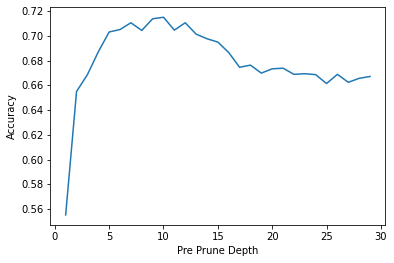

In [62]:
plt.plot(candidate_max_depth,accs)
plt.xlabel('Pre Prune Depth')
plt.ylabel('Accuracy')

Text(0, 0.5, 'F1')

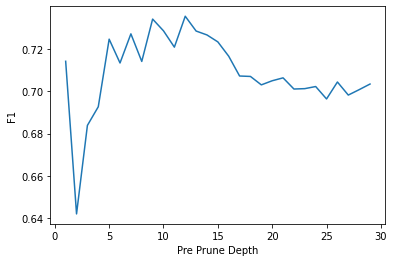

In [63]:
plt.plot(candidate_max_depth,f1s)
plt.xlabel('Pre Prune Depth')
plt.ylabel('F1')

In [64]:
best_tree_size

10

In [65]:
candidate_max_depth[int(np.argmax(f1s))]

12

In [66]:
highest_f1 = candidate_max_depth[int(np.argmax(f1s))]
accs[highest_f1]

0.7013888888888888

In [67]:
get_accuracy_decision(best_tree_size, OH_X_train, OH_X_valid, y_train, y_valid)

(0.7132936507936508, 0.7265846736045412)

In [68]:
model = DecisionTreeClassifier(max_depth=best_tree_size)
model.fit(OH_X_train, y_train)
preds_val = model.predict(OH_X_valid)
accuracy_score(y_valid, preds_val)

0.7142857142857143

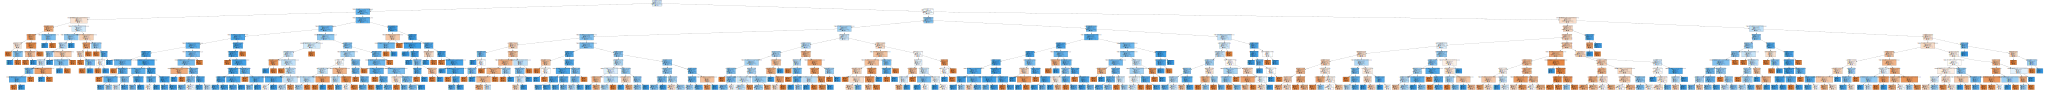

In [69]:
dot_data = tree.export_graphviz(model,filled=True,feature_names=OH_X_train.columns,class_names=['False','True'])
graph = graphviz.Source(dot_data,format='png')
graph

In [70]:
graph.render("decision_tree_no_feature_eng")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.85699 to fit


'decision_tree_no_feature_eng.png'

In [71]:
probs = model.predict_proba(OH_X_valid)

In [72]:
probs

array([[0.17886179, 0.82113821],
       [0.8525641 , 0.1474359 ],
       [0.25      , 0.75      ],
       ...,
       [0.70414537, 0.29585463],
       [0.56949153, 0.43050847],
       [0.        , 1.        ]])

In [73]:
fpr, tpr, threshold = roc_curve(y_valid,probs[:,1])
roc_auc = metrics.auc(fpr, tpr)

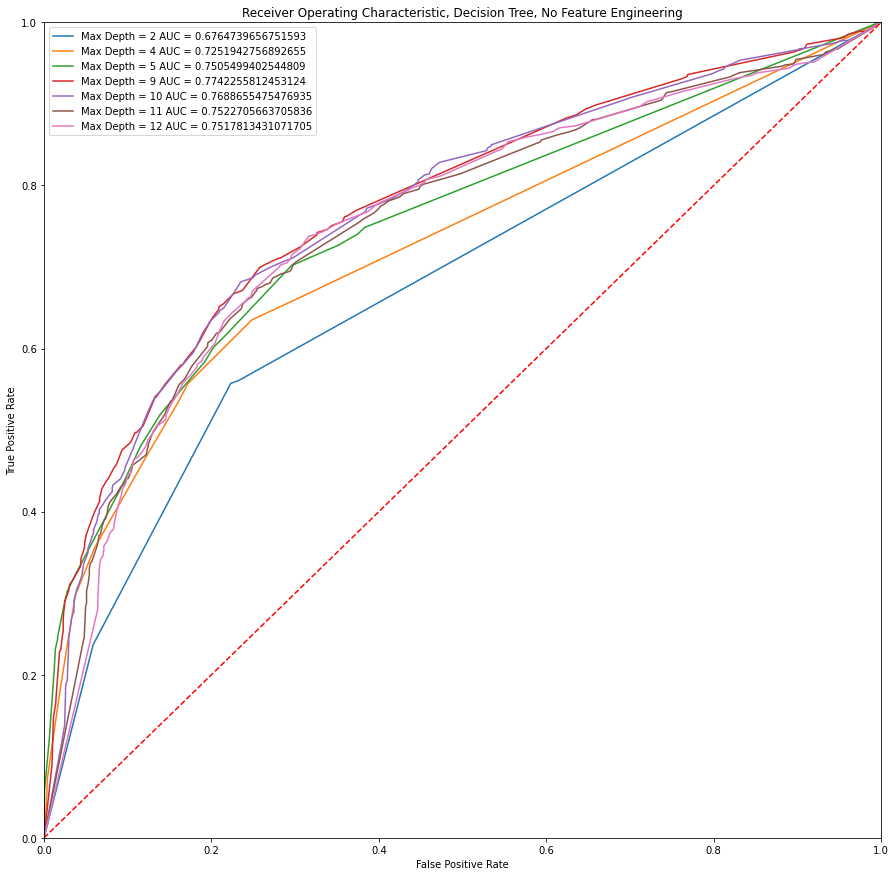

In [74]:
fig = plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic, Decision Tree, No Feature Engineering')
for depth in list(set([2,4,5,9,10,11,best_tree_size,highest_f1])):
    probs = get_probs_decision(depth, OH_X_train, OH_X_valid, y_train, y_valid)
    fpr, tpr, threshold = roc_curve(y_valid,probs[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'Max Depth = {} AUC = {}'.format(depth,roc_auc))
plt.legend()
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC Decision Tree No Feature Engineering.png')
plt.show()

### KNN ahead

In [75]:
def get_accuracy_knn(n_neighbors, train_X, val_X, train_y, val_y):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    return accuracy_score(val_y, preds_val),f1_score(val_y, preds_val)

In [76]:
def get_probs_knn(n_neighbors, train_X, val_X, train_y, val_y):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(train_X, train_y)
    probs = model.predict_proba(val_X)
    return probs

In [77]:
candidate_neighbors = list(range(2,200))

pbar = tqdm(total = len(candidate_neighbors))

accs = np.ones(len(candidate_neighbors)) * np.inf
f1s = np.ones(len(candidate_neighbors)) * np.inf

for idx, neighbors in enumerate(candidate_neighbors):
    accs[idx],f1s[idx] = get_accuracy_knn(neighbors, OH_X_train, OH_X_valid, y_train, y_valid)
    pbar.update(1)

best_n_neighbors = candidate_neighbors[int(np.argmax(accs))]

Text(0, 0.5, 'Accuracy')

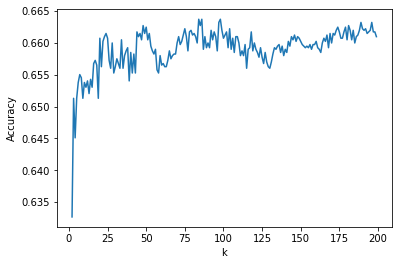

In [78]:
plt.plot(candidate_neighbors,accs)
plt.xlabel('k')
plt.ylabel('Accuracy')

Text(0, 0.5, 'F1')

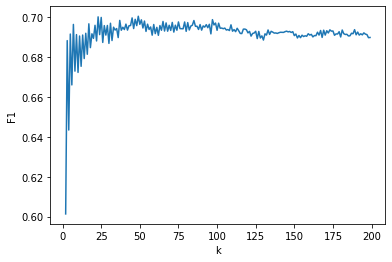

In [79]:
plt.plot(candidate_neighbors,f1s)
plt.xlabel('k')
plt.ylabel('F1')

In [80]:
best_n_neighbors

84

In [81]:
candidate_neighbors[int(np.argmax(f1s))]

49

In [82]:
highest_f1 = candidate_neighbors[int(np.argmax(f1s))]
accs[highest_f1]

0.6604662698412699

In [83]:
accs[candidate_neighbors[int(np.argmax(f1s))]]

0.6604662698412699

In [84]:
accs[candidate_neighbors[int(np.argmax(accs))]]

0.6636904761904762

In [85]:
get_accuracy_knn(best_n_neighbors, OH_X_train, OH_X_valid, y_train, y_valid)

(0.6636904761904762, 0.6959641255605381)

In [86]:
model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
model.fit(OH_X_train, y_train)
preds_val = model.predict(OH_X_valid)
accuracy_score(y_valid, preds_val)

0.6636904761904762

In [87]:
probs = model.predict_proba(OH_X_valid)

In [88]:
probs

array([[0.39285714, 0.60714286],
       [0.69047619, 0.30952381],
       [0.42857143, 0.57142857],
       ...,
       [0.46428571, 0.53571429],
       [0.44047619, 0.55952381],
       [0.4047619 , 0.5952381 ]])

In [89]:
fpr, tpr, threshold = roc_curve(y_valid,probs[:,1])
roc_auc = metrics.auc(fpr, tpr)

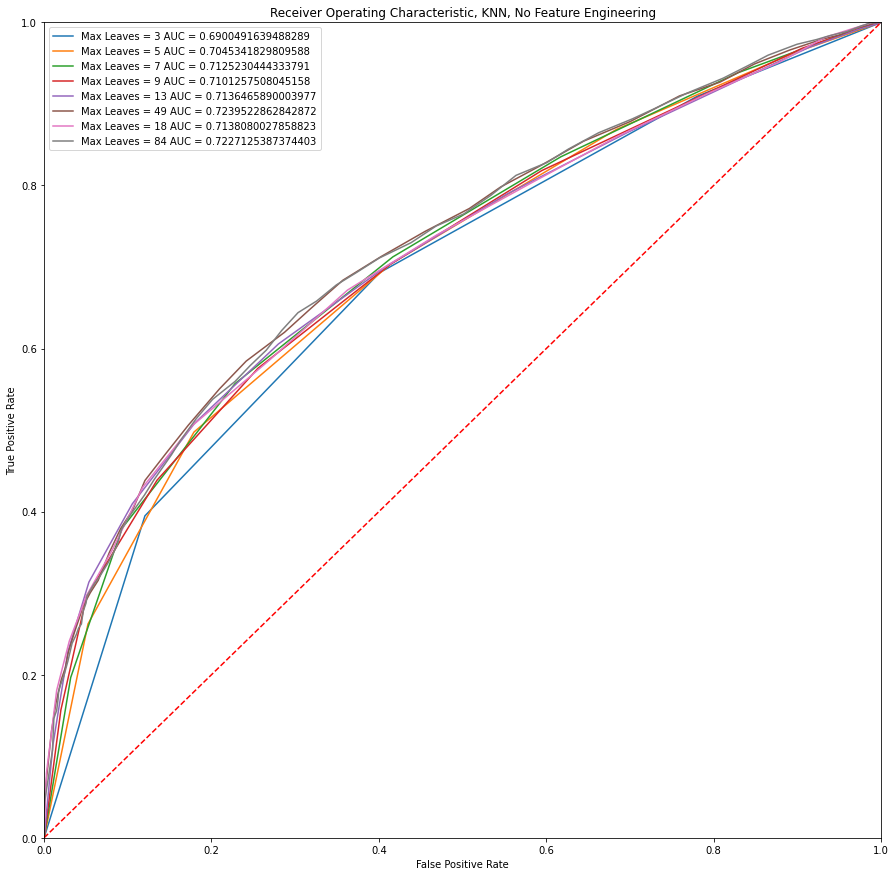

In [90]:
fig = plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic, KNN, No Feature Engineering')
for neighbors in list(set([3,5,7,9,13,18,best_n_neighbors,highest_f1])):
    probs = get_probs_knn(neighbors, OH_X_train, OH_X_valid, y_train, y_valid)
    fpr, tpr, threshold = roc_curve(y_valid,probs[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'Max Leaves = {} AUC = {}'.format(neighbors,roc_auc))
plt.legend()
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC KNN No Feature Engineering.png')
plt.show()

# After Feature Processing

In [91]:
df.columns

Index(['YEAR', 'MONTH', 'DATE', 'ORIGIN TIME(UTC)', 'Mw', 'LAT (N)',
       'LONG (E)', 'DEPTH (km)', 'REFERENCE', 'TIMESTAMP', 'label', 'Last Eq',
       'Last Major Eq', 'Frequency(Years)', 'numEq', 'numMajor', 'timeRatio',
       'timeMajorRatio'],
      dtype='object')

In [92]:
y = df['label']
X = df.drop(['label','Mw'],axis = 1)

In [93]:
[col for col in X.columns if X[col].isnull().any()]

[]

In [94]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [95]:
def get_preds_regressor(X_train, X_valid, y_train, y_valid, n_estimators=100):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return preds

def get_preds_classifier(X_train, X_valid, y_train, y_valid, n_estimators=100):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return preds

In [96]:
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
object_cols

['REFERENCE']

In [97]:
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('REFERENCE', 11)]

In [98]:
OHencode = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_X_train = pd.DataFrame(OHencode.fit_transform(X_train[object_cols]))
OH_cols_X_valid = pd.DataFrame(OHencode.transform(X_valid[object_cols]))

OH_cols_X_train.index = X_train.index
OH_cols_X_valid.index = X_valid.index

OH_X_train = X_train.copy()
OH_X_valid = X_valid.copy()

OH_X_train = OH_X_train.drop(object_cols,axis = 1)
OH_X_valid = OH_X_valid.drop(object_cols,axis = 1)

OH_X_train = pd.concat([OH_X_train, OH_cols_X_train],axis = 1) # Your code here
OH_X_valid = pd.concat([OH_X_valid, OH_cols_X_valid], axis = 1) # Your code here

In [99]:
OH_X_train.columns

Index([            'YEAR',            'MONTH',             'DATE',
       'ORIGIN TIME(UTC)',          'LAT (N)',         'LONG (E)',
             'DEPTH (km)',        'TIMESTAMP',          'Last Eq',
          'Last Major Eq', 'Frequency(Years)',            'numEq',
               'numMajor',        'timeRatio',   'timeMajorRatio',
                        0,                  1,                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                        9,                 10],
      dtype='object')

In [100]:
def get_accuracy_decision(max_depth, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    return accuracy_score(val_y, preds_val),f1_score(val_y, preds_val)

In [101]:
def get_probs_decision(max_depth, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(train_X, train_y)
    probs = model.predict_proba(val_X)
    return probs

In [102]:
candidate_max_depth = list(range(1,30))
accs = np.ones(len(candidate_max_depth)) * np.inf
f1s = np.ones(len(candidate_max_depth)) * np.inf
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
for idx, lnodes in enumerate(candidate_max_depth):
    accs[idx],f1s[idx] = get_accuracy_decision(lnodes, OH_X_train, OH_X_valid, y_train, y_valid)
# Store the best value of max_leaf_nodes (it will be either 5, 25, 50, 100, 250 or 500)
best_tree_size = candidate_max_depth[int(np.argmax(accs))]

Text(0, 0.5, 'Accuracy')

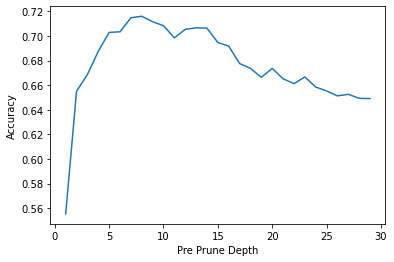

In [103]:
plt.plot(candidate_max_depth,accs)
plt.xlabel('Pre Prune Depth')
plt.ylabel('Accuracy')

Text(0, 0.5, 'F1')

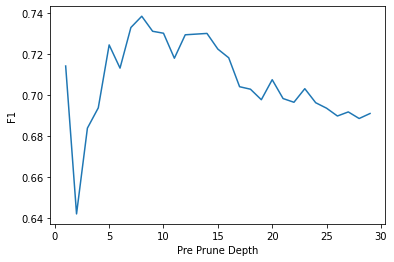

In [104]:
plt.plot(candidate_max_depth,f1s)
plt.xlabel('Pre Prune Depth')
plt.ylabel('F1')

In [105]:
best_tree_size

8

In [106]:
candidate_max_depth[int(np.argmax(f1s))]

8

In [107]:
highest_f1 = candidate_max_depth[int(np.argmax(f1s))]
accs[highest_f1]

0.7115575396825397

In [108]:
get_accuracy_decision(best_tree_size, OH_X_train, OH_X_valid, y_train, y_valid)

(0.7172619047619048, 0.739488117001828)

In [109]:
model = DecisionTreeClassifier(max_depth=best_tree_size)
model.fit(OH_X_train, y_train)
preds_val = model.predict(OH_X_valid)
accuracy_score(y_valid, preds_val)

0.7155257936507936

In [110]:
dot_data = tree.export_graphviz(model,filled=True,feature_names=OH_X_train.columns,class_names=['False','True'])
graph = graphviz.Source(dot_data,format='png')

In [111]:
graph.render("decision_tree")

'decision_tree.png'

In [112]:
probs = model.predict_proba(OH_X_valid)

In [113]:
probs

array([[0.24587156, 0.75412844],
       [0.72922252, 0.27077748],
       [0.64884005, 0.35115995],
       ...,
       [0.64884005, 0.35115995],
       [0.43672457, 0.56327543],
       [0.59633028, 0.40366972]])

In [114]:
fpr, tpr, threshold = roc_curve(y_valid,probs[:,1])
roc_auc = metrics.auc(fpr, tpr)

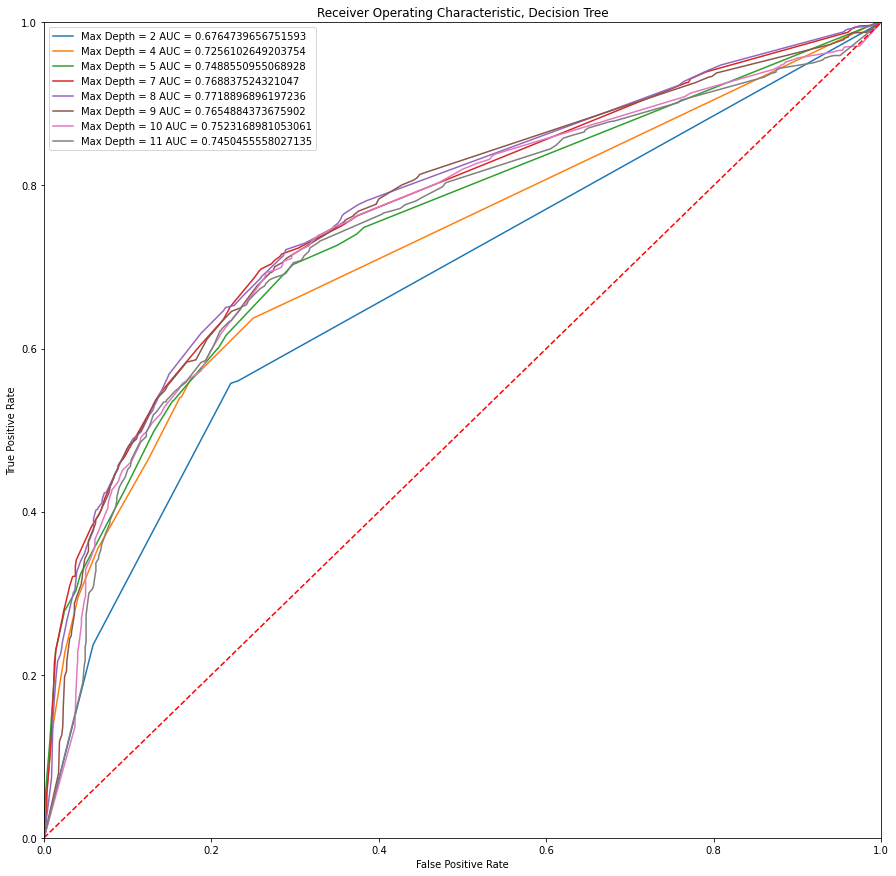

In [115]:
fig = plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic, Decision Tree')
for depth in list(set([2,4,5,7,9,10,11,best_tree_size,highest_f1])):
    probs = get_probs_decision(depth, OH_X_train, OH_X_valid, y_train, y_valid)
    fpr, tpr, threshold = roc_curve(y_valid,probs[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'Max Depth = {} AUC = {}'.format(depth,roc_auc))
plt.legend()
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC Decision Tree.png')
plt.show()

### KNN ahead

In [204]:
df.columns

Index(['YEAR', 'MONTH', 'DATE', 'ORIGIN TIME(UTC)', 'Mw', 'LAT (N)',
       'LONG (E)', 'DEPTH (km)', 'REFERENCE', 'TIMESTAMP', 'label', 'Last Eq',
       'Last Major Eq', 'Frequency(Years)', 'numEq', 'numMajor', 'timeRatio',
       'timeMajorRatio'],
      dtype='object')

In [228]:
y = df['label']
X = df.drop(['label','Mw','Last Eq','ORIGIN TIME(UTC)', 'numEq', 'timeRatio', 'TIMESTAMP','Frequency(Years)','Last Major Eq'],axis = 1)

In [229]:
[col for col in X.columns if X[col].isnull().any()]

[]

In [230]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [231]:
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
object_cols

['REFERENCE']

In [232]:
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('REFERENCE', 11)]

In [233]:
OHencode = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_X_train = pd.DataFrame(OHencode.fit_transform(X_train[object_cols]))
OH_cols_X_valid = pd.DataFrame(OHencode.transform(X_valid[object_cols]))

OH_cols_X_train.index = X_train.index
OH_cols_X_valid.index = X_valid.index

OH_X_train = X_train.copy()
OH_X_valid = X_valid.copy()

OH_X_train = OH_X_train.drop(object_cols,axis = 1)
OH_X_valid = OH_X_valid.drop(object_cols,axis = 1)

OH_X_train = pd.concat([OH_X_train, OH_cols_X_train],axis = 1) # Your code here
OH_X_valid = pd.concat([OH_X_valid, OH_cols_X_valid], axis = 1) # Your code here

In [234]:
OH_X_train.columns

Index([          'YEAR',          'MONTH',           'DATE',        'LAT (N)',
             'LONG (E)',     'DEPTH (km)',       'numMajor', 'timeMajorRatio',
                      0,                1,                2,                3,
                      4,                5,                6,                7,
                      8,                9,               10],
      dtype='object')

In [235]:
def get_accuracy_knn(n_neighbors, train_X, val_X, train_y, val_y):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    return accuracy_score(val_y, preds_val),f1_score(val_y, preds_val)

In [236]:
def get_probs_knn(n_neighbors, train_X, val_X, train_y, val_y):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(train_X, train_y)
    probs = model.predict_proba(val_X)
    return probs

In [237]:
candidate_neighbors = list(range(2,200))

pbar = tqdm(total = len(candidate_neighbors))

accs = np.ones(len(candidate_neighbors)) * np.inf
f1s = np.ones(len(candidate_neighbors)) * np.inf

for idx, neighbors in enumerate(candidate_neighbors):
    accs[idx],f1s[idx] = get_accuracy_knn(neighbors, OH_X_train, OH_X_valid, y_train, y_valid)
    pbar.update(1)

best_n_neighbors = candidate_neighbors[int(np.argmax(accs))]

Text(0, 0.5, 'Accuracy')

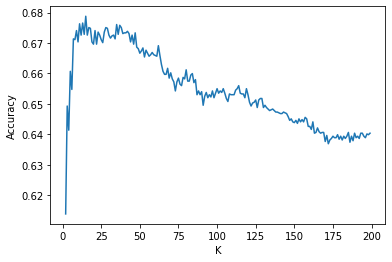

In [238]:
plt.plot(candidate_neighbors,accs)
plt.xlabel('K')
plt.ylabel('Accuracy')

Text(0, 0.5, 'F1')

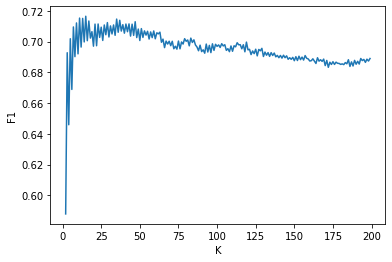

In [239]:
plt.plot(candidate_neighbors,f1s)
plt.xlabel('K')
plt.ylabel('F1')

In [240]:
best_n_neighbors

15

In [241]:
highest_f1 = candidate_neighbors[int(np.argmax(f1s))]
accs[highest_f1]

0.6750992063492064

In [242]:
candidate_neighbors[int(np.argmax(f1s))]

15

In [243]:
accs[candidate_neighbors[int(np.argmax(f1s))]]

0.6750992063492064

In [244]:
accs[candidate_neighbors[int(np.argmax(accs))]]

0.6750992063492064

In [245]:
get_accuracy_knn(best_n_neighbors, OH_X_train, OH_X_valid, y_train, y_valid)

(0.6788194444444444, 0.7164440551784541)

In [246]:
model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
model.fit(OH_X_train, y_train)
preds_val = model.predict(OH_X_valid)
accuracy_score(y_valid, preds_val)

0.6788194444444444

In [247]:
probs = model.predict_proba(OH_X_valid)

In [248]:
probs

array([[0.33333333, 0.66666667],
       [0.73333333, 0.26666667],
       [0.66666667, 0.33333333],
       ...,
       [0.73333333, 0.26666667],
       [0.73333333, 0.26666667],
       [0.66666667, 0.33333333]])

In [249]:
fpr, tpr, threshold = roc_curve(y_valid,probs[:,1])
roc_auc = metrics.auc(fpr, tpr)

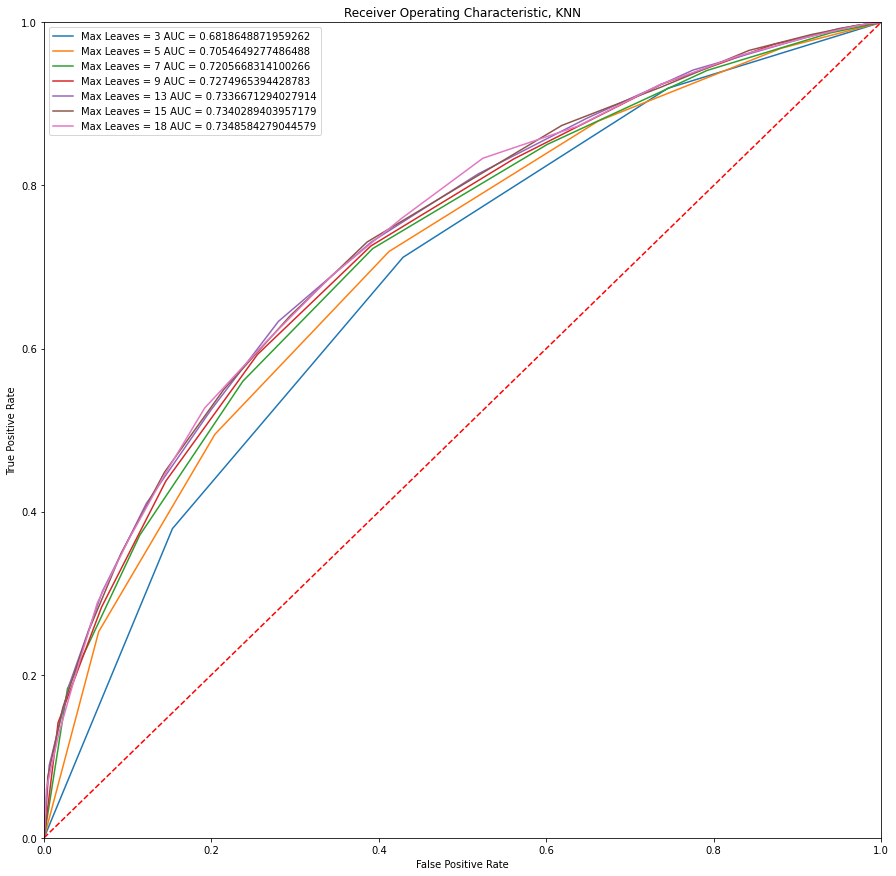

In [250]:
fig = plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic, KNN')
for neighbors in list(set([3,5,7,9,13,18,best_n_neighbors,highest_f1])):
    probs = get_probs_knn(neighbors, OH_X_train, OH_X_valid, y_train, y_valid)
    fpr, tpr, threshold = roc_curve(y_valid,probs[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'Max Leaves = {} AUC = {}'.format(neighbors,roc_auc))
plt.legend()
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC KNN.png')
plt.show()